In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
%matplotlib inline

In [2]:
data_dir = './stanford-car-dataset-by-classes-folder/car_data/'
train_dir = data_dir + 'train'
test_dir = data_dir + 'test'

In [12]:
training_transforms = transforms.Compose([transforms.RandomRotation(30), 
                                          transforms.RandomResizedCrop(224), 
                                          transforms.RandomHorizontalFlip(), 
                                          transforms.ToTensor()])
validation_tranforms = transforms.Compose([transforms.Resize(256), 
                                         transforms.CenterCrop(224), 
                                         transforms.ToTensor()])
testing_transforms = transforms.Compose([transforms.Resize(256), 
                                         transforms.CenterCrop(224), 
                                         transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_data = datasets.ImageFolder(train_dir, transform=validation_tranforms)
test_data = datasets.ImageFolder(test_dir, transform=testing_transforms)

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))
np.random.shuffle(indices)
from torch.utils.data.sampler import SubsetRandomSampler
train_idx, validation_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)
train_loader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
validate_loader = torch.utils.data.DataLoader(validation_data,
                   sampler=validation_sampler, batch_size=64)

#train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.vgg16(pretrained=True)

In [14]:
for param in model.parameters():
    param.requires_grad = False
    
from collections import OrderedDict
    
model.classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)), 
                                              ('relu', nn.ReLU()), 
                                              ('drop', nn.Dropout(0.5)), 
                                              ('fc2', nn.Linear(5000, 196)), 
                                              ('output', nn.LogSoftmax(dim=1))]))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [15]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, validation_losses = [], []

for epoch in range(epochs):
    print(len(train_loader))
    for inputs, labels in train_loader:
        steps += 1
        print(steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            val_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                print(len(validate_loader))
                for inputs, labels in validate_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    val_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(train_loader))
            validation_losses.append(val_loss/len(validate_loader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {val_loss/len(validate_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(validate_loader):.3f}")
            running_loss = 0
            model.train()
            
torch.save(model, 'aerialmodel.pth')

102
1
2
3
4
5
6
7
8
9
10
26


KeyboardInterrupt: 

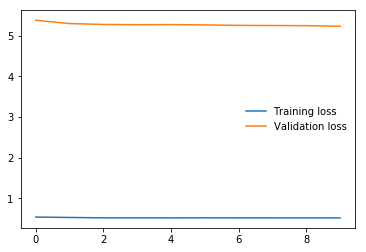

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()